In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output("ls ../input", shell = True).decode("utf8"))

# Any results you write to the current directory are saved as output.

holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
test_sample.csv
train.csv
train_sample.csv
transactions.csv



# train.csv

In [2]:
# load in the training data
# the number of rows (approximately) that should be loaded.  Set this negative to get all the data
numDesiredRows = 1000000

if numDesiredRows < 0:
    skiprows = 0
else:
    step = math.ceil(125000000. / numDesiredRows)
    skiprows = lambda x: x != 0 and x % step != 0

train_df = pd.read_csv('../input/train.csv', header = 0, index_col = 'id', 
                       parse_dates = ['date'], dtype = {'onpromotion': bool}, skiprows = skiprows)
print(train_df.columns)
print(train_df.dtypes)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'date', u'store_nbr', u'item_nbr', u'unit_sales', u'onpromotion'], dtype='object')
date           datetime64[ns]
store_nbr               int64
item_nbr                int64
unit_sales            float64
onpromotion            object
dtype: object


/usr/local/lib/python2.7/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# Take a look at the first few rows
train_df.head(5)

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
124,2013-01-01,25,315322,1.0,NaN
249,2013-01-01,25,564533,1.0,NaN
374,2013-01-01,25,809183,1.0,NaN
499,2013-01-01,25,1004550,32.0,NaN
624,2013-01-02,1,127534,4.0,NaN


In [4]:
# get the number of training examples
len(train_df)

1003976

In [5]:
# get some basic summary stats for the number of sales
train_df['unit_sales'].describe()

count    1.003976e+06
mean     8.562639e+00
std      2.033525e+01
min     -5.500000e+01
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      4.809000e+03
Name: unit_sales, dtype: float64

In [6]:
# we're told a negative unit_sales means items were returned.  Check how often that occurs
len(train_df[train_df.unit_sales < 0])

51

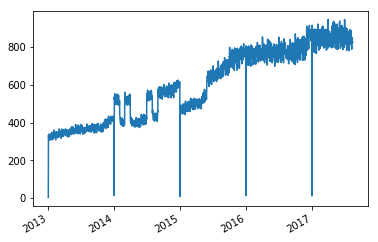

In [7]:
# get the number of buy events by date
train_df['date'].value_counts().plot()

In [8]:
#The number of buy events at different stores
train_df['store_nbr'].value_counts()

44    28131
45    27883
47    27654
3     27218
46    26810
49    26723
8     26086
48    25916
50    25534
6     24709
2     23906
51    23671
7     23377
37    22645
4     22633
9     22180
24    22163
38    21827
5     21354
39    21108
27    21024
11    20504
1     20482
41    20015
28    19371
23    18946
31    18908
34    18381
36    17703
18    17562
17    17312
40    16821
25    16449
33    15725
53    15529
15    15500
43    15495
19    15039
12    14715
16    14562
14    14462
26    14366
10    13952
13    13880
20    13305
54    13193
30    12752
29    12064
42    11720
35    11085
21    11016
32    10911
22     7378
52     2321
Name: store_nbr, dtype: int64

In [9]:
#The number of buy events at different stores
train_df['item_nbr'].value_counts()

692537     694
559870     691
162066     687
258396     684
414750     682
273528     681
1105212    677
839363     672
414353     661
315176     661
567623     660
115267     660
841842     660
850333     659
1146795    657
265559     655
314384     654
208384     654
1084881    653
1047772    653
847863     652
621300     652
502331     651
807493     648
261053     648
265279     647
1036689    647
938566     646
165594     645
1047681    645
          ... 
1988467      4
2090125      4
2089036      4
2089250      4
2062477      4
2087409      3
2054300      3
2056876      3
1939239      3
2010082      3
2122188      3
2088946      3
2035576      3
2089224      3
2011450      2
2045493      2
2011457      2
2008567      1
2011448      1
1993625      1
2123727      1
2123775      1
2127114      1
2120723      1
2075374      1
2123711      1
2122868      1
2123750      1
2123791      1
2011451      1
Name: item_nbr, Length: 4006, dtype: int64

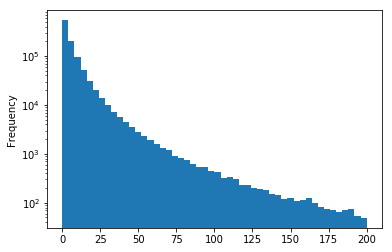

In [10]:
# distribution of the number of items being bought
pos_sales = train_df.unit_sales >= 0
small_sales = train_df.unit_sales <= 200
train_df.unit_sales[pos_sales & small_sales].plot.hist(bins = 50, log=True)

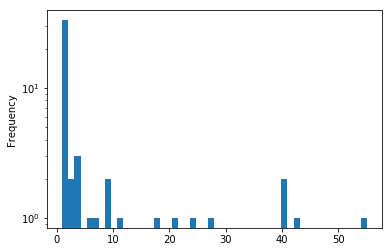

In [11]:
# distribution of the number of items being returned
train_df[train_df.unit_sales < 0].unit_sales.apply(lambda x: -x).plot.hist(bins = 50, log = True)

In [15]:
# check how many of the onpromotion values are missing, how many are true, and how many are false
naOnPromotions = train_df[pd.isna(train_df.onpromotion)]
onPromotions = train_df[train_df.onpromotion == True]
notOnPromotions = train_df[train_df.onpromotion == False]
print("num NA onpromotion: %d\nnum onpromotion: %d\nnum not onpromotion: %d\ntotal: %d" % 
              (len(naOnPromotions), len(onPromotions), len(notOnPromotions), len(train_df)))

num NA onpromotion: 173261
num onpromotion: 62717
num not onpromotion: 767998
total: 1003976


Based on the counts above, as well as just common sense, it seems like missing onpromotion values should probably be filled in as being False

# oil.csv

In [16]:
# load in the oil data
oil_df = pd.read_csv('../input/oil.csv', header = 0 , index_col = 'date', 
                     parse_dates = ['date'], names = ['date', 'price'], dtype = {'price': np.dtype('float64')})
print(oil_df.columns)
print(oil_df.dtypes)

Index([u'price'], dtype='object')
price    float64
dtype: object


In [17]:
# examine the first few rows
oil_df.head(5)

,price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [18]:
# some basic stats about the oil prices
oil_df.describe()

,price
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


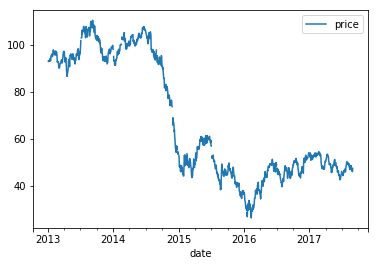

In [19]:
# check the oil price over time graph
oil_df.plot()

In [20]:
# get the number of dates with oil price and the number without 
numNA = len(oil_df.price[pd.isna(oil_df.price)])
print("w/ oil price: %d    w/o oil price: %d" % (len(oil_df) - numNA, numNA))

w/ oil price: 1175    w/o oil price: 43


In [21]:
# check how long the consecutive runs of missing data are
consecMissing = [0]
for date in oil_df.index:
    if pd.isna(oil_df.price[date]):
        consecMissing[-1] += 1
    elif consecMissing[-1] > 0:
        consecMissing.append(0)
        
if consecMissing[-1] == 0:
    consecMissing = consecMissing[:-1]
        
print(consecMissing)
print(sum(consecMissing))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
43


We see that there is at most two days in a row missing oil prices, so it would probably be fine to simply interpolate the price to get rid of the missing values.